In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
#from torchvision.models.detection.anchor_utils import AnchorGenerator

In [2]:
import numpy as np
from PIL import Image
from torchvision.transforms import transforms as transforms
import time

In [3]:
# pairs of edges for 17 of the keypoints detected from try and error
edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
    (5, 7), (7, 9), (5, 11), (11, 13), (13, 15), (6, 12),
    (12, 14), (14, 16), (5, 6)
]
point = np.asarray(edges)
point_numbers = len(set(point.flatten()))

In [4]:
def draw_keypoints_and_boxes(outputs, image,pullups=0):
    # the `outputs` is list which in-turn contains the dictionary 
    cor = []
    sucuess = False
    for i in range(len(outputs[0]['keypoints'])):
        # get the detected keypoints
        keypoints = outputs[0]['keypoints'][i].cpu().detach().numpy()
        #print("keypoints",keypoints)
        # get the detected bounding boxes
        boxes = outputs[0]['boxes'][i].cpu().detach().numpy()
    
        # proceed to draw the lines and bounding boxes 
        if outputs[0]['scores'][i] > 0.8 and sucuess == False: # proceed if confidence is above 0.8
            sucuess=True
            
            #"Text"
            cv2.putText(image, str(pullups), (80,80), cv2.FONT_HERSHEY_SIMPLEX, 
                   2, (0, 0, 255), thickness=3, lineType=cv2.LINE_AA)
            
            
            keypoints = keypoints[:, :].reshape(-1, 3)
            cor = [keypoints[:, :-1]]
            
            for p in range(keypoints.shape[0]):
                # draw the keypoints
                cv2.circle(image, (int(keypoints[p, 0]), int(keypoints[p, 1])), 
                            3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            # draw the lines joining the keypoints
            for ie, e in enumerate(edges):
                # get different colors for the edges
                rgb = matplotlib.colors.hsv_to_rgb([
                    ie/float(len(edges)), 1.0, 1.0
                ])
                rgb = rgb*255
                # join the keypoint pairs to draw the skeletal structure
                #print(e,(keypoints[e, 0][0], keypoints[e, 1][0]),
                #        (keypoints[e, 0][1], keypoints[e, 1][1]))
                cv2.line(image, (keypoints[e, 0][0], keypoints[e, 1][0]),
                        (keypoints[e, 0][1], keypoints[e, 1][1]),
                        tuple(rgb), 5, lineType=cv2.LINE_AA)
            
            # draw the bounding boxes around the objects
            
            cv2.rectangle(image, (int(boxes[0]), int(boxes[1])), (int(boxes[2]), int(boxes[3])),
                          color=(0, 255, 0), 
                          thickness=10)
        else:
            continue
    return image,sucuess,cor 

In [5]:
def get_model(min_size=800):
    # initialize the model
    # or keypointrcnn_resnet50_fpn
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True,
                                                                   num_keypoints=point_numbers, 
                                                                   min_size=min_size)
    #backbone=torchvision.models.mobilenet_v2(pretrained=True).features
    #backbone.out_channels = 1280
    #anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),aspect_ratios=((0.5, 1.0, 2.0),))
    #roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],output_size=7, sampling_ratio=2)
    #keypoint_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
    #                                                                     output_size=14,sampling_ratio=2)
    #model = torchvision.models.detection.KeypointRCNN(backbone,num_classes=2,
    #                                                  rpn_anchor_generator=anchor_generator,
    #                                                  box_roi_pool=roi_pooler,
    #                                                    keypoint_roi_pool=keypoint_roi_pooler)
    
    return model

In [6]:
# transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

In [7]:
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
model = get_model().to(device).eval()

In [8]:
# Test on single figure
args={}
args['input'] = "Free_use_human_standing_simple.jpg"
image_path = args['input']
image = cv2.imread(image_path)
#image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
# NumPy copy of the image for OpenCV functions
orig_numpy = np.array(image, dtype=np.float32)
# convert the NumPy image to OpenCV BGR format
orig_numpy = cv2.cvtColor(orig_numpy, cv2.COLOR_RGB2BGR) / 255.
# transform the image
image = transform(image)
# add a batch dimension
image = image.unsqueeze(0).to(device)
# get the detections, forward pass the image through the model
with torch.no_grad():
    outputs = model(image)
# draw the keypoints, lines, and bounding boxes
output_image,sucess,cor = draw_keypoints_and_boxes(outputs, orig_numpy)

In [9]:
outputs;

In [10]:
cor;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


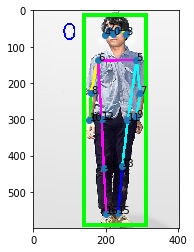

In [11]:
plt.imshow(output_image)
coordinate = outputs[0]['keypoints'][0].cpu().detach().numpy()
plt.scatter(coordinate[:,0],coordinate[:,1])
plt.xlim([0,image.shape[3]])
plt.ylim([image.shape[2],0])
for i,p in enumerate( coordinate):
    #print(p)
    plt.text(p[0],p[1],str(i))

In [12]:
coordinate

array([[219.99432 ,  65.359276,   1.      ],
       [233.02655 ,  53.834274,   1.      ],
       [208.46584 ,  55.337536,   1.      ],
       [256.08356 ,  65.86037 ,   1.      ],
       [196.93732 ,  67.864716,   1.      ],
       [284.65417 , 137.01474 ,   1.      ],
       [178.8927  , 138.0169  ,   1.      ],
       [294.1777  , 228.21259 ,   1.      ],
       [159.34436 , 228.21259 ,   1.      ],
       [284.65417 , 294.35608 ,   1.      ],
       [155.33446 , 301.3713  ,   1.      ],
       [260.09344 , 302.87457 ,   1.      ],
       [188.9175  , 298.86588 ,   1.      ],
       [245.55754 , 429.1485  ,   1.      ],
       [194.93236 , 433.6583  ,   1.      ],
       [234.53026 , 557.9279  ,   1.      ],
       [201.44847 , 559.9323  ,   1.      ]], dtype=float32)

In [13]:
image.shape

torch.Size([1, 3, 599, 401])

In [14]:
#!mkdir outputs
#args['input'] = "/home/sam/Dropbox/Camera Uploads/PXL_20210413_224318815.mp4"
args['input'] = 0 #webcam
args['min_size']=800
cap = cv2.VideoCapture(args['input'])
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')
# get the video frames' width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
# set the save path
save_path = "./outputs/real_time_"+str(args['min_size'])+".mp4"

w=400           #change w and h for dimensions 
h=frame_height  #of interested area

out = cv2.VideoWriter(save_path, 
                      cv2.VideoWriter_fourcc(*'mp4v'), 5, 
                      (w,h)) 
print(frame_height,frame_width)
frame_count = 0 # to count total frames
total_fps = 0 # to get the final frames per second

480 640


In [15]:
# read until end of video
h0,w0=0,0 #origin coordinate for interested area
cors=[]
num_frame=0
frames=[]
state=-1 #-1 = down, 1 = up
pullups=0
initial_time =time.time()
delta = 3 #wait 3 second to start
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    frame = frame[h0:h0+h,w0:w0+w,:] 
    #print(frame.shape)
    #frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
    #count+=1
    if ret == True and time.time()-initial_time>delta:
        #print(count)
        #print(frame)
        pil_image = Image.fromarray(frame).convert('RGB')
        orig_frame = frame
        # transform the image
        image = transform(pil_image)
        # add a batch dimension
        image = image.unsqueeze(0).to(device)
        # get the start time
        start_time = time.time()
        # get the detections, forward pass the frame through the model
        with torch.no_grad():
            output_image = model(image)
            #print("max score",np.max(output_image[0]['scores'].cpu().detach().numpy()))
        # get the end time
        end_time = time.time()
        output_image,sucess,cor = draw_keypoints_and_boxes(output_image, orig_frame,pullups)
        if(sucess==False):continue
        ys = np.mean(cor[0][1:5,1]) #1~4=face
        th = np.mean(cor[0][7:9,1]) # 7 &8  elbows / 5&6 shoulders
        #print(ys,th,state,(ys<th),(ys<th)*state,cor[0][7,1],cor[0][5,1])
        if((np.sign(ys-th)*state)==-1):
            pullups+=(state==1)*(cor[0][7,1]<cor[0][5,1] or cor[0][8,1]<cor[0][6,1])
            state*=-1
        num_frame+=1
        #print(num_frame)
        cors+=[cor]
        frames+=[frame]
        # get the fps
        fps = 1 / (end_time - start_time)
        # add fps to total fps
        total_fps += fps
        # increment frame count
        frame_count += 1
        wait_time = max(40, int(fps/4))
        #ims = cv2.resize(output_image, (h,w))  
        #print(output_image.shape)
        cv2.imshow('Pose detection frame', output_image)
        out.write(output_image)
        
        #out.write(frame)
        
        # press `q` to exit
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break
    elif(ret == False):
        break

In [16]:
#len(cors)

In [17]:
#len(frames)

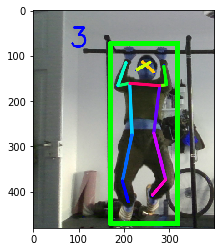

In [18]:
plt.imshow(frames[30])

(480, 0)

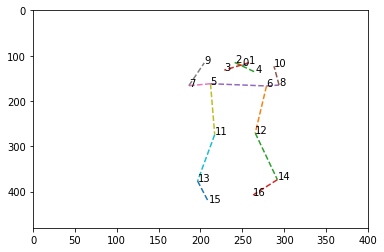

In [19]:
cors=np.asarray(cors)
for cor in cors[30:31]:
    for i,p in enumerate(cor[0]):
        #print(p)
        plt.text(p[0],p[1],str(i))
    for e in edges:
        x = [cor[0][e[0],0],cor[0][e[1],0]]
        y = [cor[0][e[0],1],cor[0][e[1],1]]
        x=np.asarray(x)
        y=np.asarray(y)
        plt.plot(x,y,'--')
plt.xlim([0,w])
plt.ylim([h,0])


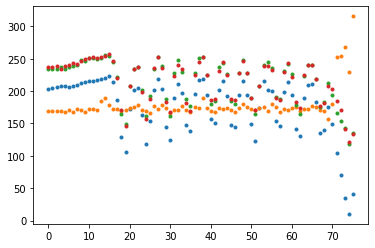

In [20]:
ys = [np.mean(cor[0][1:5,1]) for cor in cors]
ys2 = [np.mean(cor[0][7:9,1]) for cor in cors]
ys3 = [cor[0][5,1] for cor in cors]
ys4 = [cor[0][6,1] for cor in cors]

plt.plot(ys,".")
plt.plot(ys2,".")
plt.plot(ys3,".")
plt.plot(ys4,".")
#plt.ylim([190,210])

In [21]:
#ys

In [25]:
# release VideoCapture()
cap.release()
# close all frames and video windows
cv2.destroyAllWindows()
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

#####no idea why, but without it output video will not working 
save_path = "./outputs/dummpy.mp4"
# define codec and create VideoWriter object 
#w,h = 540,960
out = cv2.VideoWriter(save_path, 
                      cv2.VideoWriter_fourcc(*'mp4v'), 20, 
                      (frame_width,frame_height))
import os
os.system("rm ./outputs/dummpy.mp4")

Average FPS: 3.062


0